In [2]:
# If running notebook on brainlife, use ! due to version issues
# !pip install llvmlite --ignore-installed # added due to issue with (un)installing correct version
# !pip install git+https://github.com/JulioAPeraza/gradec.git

In [3]:
import itertools
import os.path as op
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gradec.decode import LDADecoder
from gradec.utils import _rm_medial_wall, _decoding_filter
from gradec.plot import plot_surf_maps, plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
import nibabel as nib

### Determine tract names given a data folder with cortical surface termination maps - Change Threshold as Needed

In [4]:
# Path to cortical surface termination maps
threshold = '0' # MODIFY THRESHOLD TO 0.15, 0.25, ETC...
smooth = 'smooth' # MODIFY SMOOTH TO 'no_smooth' or 'smooth
data_dir = op.join(".", "data")
endpt_dir = op.join(
    data_dir, 
    "white-matter-atlas_thresholds", 
    f"1062_cortexmap_binarize_{smooth}-surf-1_threshold-{threshold}_dilate-0", ### MODIFY AS NEEDED
    "cortexmap", 
    "func",
)

# extract all .gii file names
file_names = []
for f in os.listdir(endpt_dir):
    if f.endswith(".gii"):
        file_names.append(f)

tracts_names = [] # all tract names differeniating between left and right tract (ex. left CST and right CST treated as 2 tracts)

# extract tract name from file name
for i in file_names:
    if ("rh.left" in i) or ("lh.right" in i) or ('spino' in i) or ('Cerebellar' in i):
        continue # exclude if file name "rh.left..." or "lh.right..." or spinal/cerebellar tracts
    else:
        tracts_names.append(i.split("_")[0][len('rh.'):])

ALL_TRACT_NAMES = sorted(list(set(tracts_names)))

### Define space, density and paths to data

In [5]:
SPACE, DENSITY = "fsaverage", "164k"
DSET, MODEL = "neuroquery", "lda"

# data_dir = op.join(".", "data") # duplicate from code above
neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, f"figures_{smooth}_{threshold}")

# List of posssible combinations of tracts, end points and smoothing
tracts = ALL_TRACT_NAMES
endpts = ["RAS", "LPI"]
#tracts = ["Arc", "SLF1And2", "CST"]
#smths = ["", ".smooth_1"]
#thresholds = ["0", "0.15", "0.25"]

# Dictionaries for the title of the figures 
TRACTS_DICT = dict(zip(ALL_TRACT_NAMES, ALL_TRACT_NAMES)) # need to eventually change
SMTHS_DICT = {
    "": "Unsmoothed",
    ".smooth_1": "Smoothed",
}
ENDPOINTS_DICT = { 
    "LPI": "Left-Posterior-Inferior",
    "RAS": "Right-Anterior-Superior",
}

### Train and LDA-based decoder on NeuroQuery detabase 

In [6]:
decode = LDADecoder(space=SPACE, density=DENSITY, calc_pvals=False, data_dir=data_dir)
decode.fit(DSET)

# Load features for analysis or visualization
features = _fetch_features(DSET, MODEL, data_dir=data_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=data_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=data_dir)

### Define functions to run decoder

In [7]:
file_smooth = 'smooth_3.'  ### CHANGE TO SMOOTH_3. OR EMPTY STRING
def load_maps_per_tract(endpt_dir, tract):
    """
    This function loads maps when running analysis per tract (leftCST and rightCST = 2 tracts)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): full name of tract (ex. can include whether tract is 'left' or 'right' tract)

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    if 'left' in tract:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
    elif 'right' in tract:
        map_lpi_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
    else: # if mono tract
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
        
    return map_arr_lh, map_arr_rh

In [8]:
def load_combined_maps(endpt_dir, tract, isMono):
    """
    This function loads maps when running analysis for combined endpoint ROIs (RAS+LPI)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    if isMono:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
    else: # if bi tracts
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        
    return map_arr_lh, map_arr_rh

In [9]:
def load_mono_maps(endpt_dir, tract, method=""):   ### MATCH-CASE DOES NOT WORK IN OLDER VERSION OF PYTHON
    """
    This function loads maps when running analysis for mono tracts, separated.
    Can be separated by hemisphere (lh vs. rh) or endpoint ROI (LPI vs. RAS). Functionally, these two are the same.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")

    match method:
        case "lh": # separated by lh or LPI
            map_arr_lh = nib.load(map_lpi_lh).agg_data()
            map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
        case "rh": # separated by rh or RAS
            map_arr_rh = nib.load(map_ras_rh).agg_data()
            map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
        case _: # default
            print("Error: No separation method provided.")
    
    return map_arr_lh, map_arr_rh

In [10]:
def load_bi_maps(endpt_dir, tract, splitby="", endpt="", hemisphere=""):  ### MATCH-CASE DOES NOT WORK IN OLDER VERSION OF PYTHON
    """
    This function loads maps when running analysis for bi tracts, separated.
    Can be separated by hemisphere (lh vs. rh), endpoint ROI (LPI vs. RAS), or both.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    splitby (str): method of splitting. Can split by "roi", "hem", or "both"
    endpt (str): optional- endpoint ROI. "RAS" or "LPI"
    hemisphere (str): optional- hemisphere. "lh" or "rh"

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    LH = "lh" # left hemisphere
    RH = "rh" # right hemisphere
    LPI = "LPI" # endpoint ROI: left-posterior-inferior
    RAS = "RAS" # endpoint ROI: right-anterior-superior

    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
    map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.{file_smooth}func.gii")
    map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.{file_smooth}func.gii")

    match splitby:
        case "roi": # separated by endpoint ROI
            if endpt == LPI: 
                map_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_arr_rh = nib.load(map_lpi_rh).agg_data()
            elif endpt == RAS:
                map_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_rh = nib.load(map_ras_rh).agg_data()
            else:
                print("Error: Can't separate by endpoint ROI. Wrong ROI provided.")
        case "hem": # separated by hemisphere
            if hemisphere == LH:
                map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == RH:
                map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
                map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
                map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere 
            else:
                print("Error: Can't separate by hemisphere. Wrong hemisphere provided.")
        case "both": # separated by enpoint ROI and hemisphere
            if hemisphere == LH:
                map_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_lh = nib.load(map_lh).agg_data()
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == RH:
                map_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_rh = nib.load(map_rh).agg_data()
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere
            else:
                print("Error: Can't separate by endpoint ROI and hemisphere. Incorrect ROI or hemisphere provided.")
        case _: # default
            print("Error: Incorrect separation method provided.")
 
    return map_arr_lh, map_arr_rh

### Clustering: Run decoder for each tract 

In [11]:
### CODE WAS MODIFY TO CREATE AN EXTRA DATAFRAME, ALSO CREATES TRACT SURFACE PLOTS ENDPOINTS COMBINED
tracts_to_analyze = ALL_TRACT_NAMES # modify to just run a few tracts
map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 104 topics*33 ROIs data table in long form

d = {}
for tract in tracts_to_analyze:
    # Read map
    tract_probs = []
    map_arr_lh, map_arr_rh = load_maps_per_tract(endpt_dir, tract)

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Visualize maps to decode   #### UNCOMMENT IF WANTING SURFACE PLOTS    
    # surf_fig = plot_surf_maps(  
    #     map_arr_lh, 
    #     map_arr_rh, 
    #     space=SPACE, 
    #     density=DENSITY, 
    #     cmap="YlOrRd",
    #     color_range=(0, 1),
    #     data_dir=data_dir,
    #     out_fig=op.join(figures_dir, f"{tract}_LPI+RAS_thr-{threshold}_surf.png"),
    # ) 
    
    # for df with overlapping tracts
    for i in map_arr:   ### maps_arr has the endpoint probabilities
        if i != 0:   ### mark any probability that isn't 0 as 1
            i = 1
        tract_probs.append(i)

        # Decode map and calculate correlation of activation map and white matter termination map
    temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # filter to keep only the function-related topics
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(  
        temp_corrs_df,
        features,
        classification,
        pos_corr = False,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )  

    # transform and concat into single df for clustering
    filtered_df = filtered_df.rename(columns={0: 'r'})
    sorted_df = filtered_df.sort_values(by="r", ascending=False)  
    map_corr_df = pd.concat([map_corr_df, 
                             pd.DataFrame({'ROI': f"{tract}",
                                           'topic': sorted_df.index, 
                                           'r': sorted_df['r']})], 
                                           ignore_index=True)
        
    d[tract] = tract_probs
dat = pd.DataFrame(d)     ### dataframe shows if there is a non-zero probability of tract ending in vertex (0-no probability, 1-non-zero probability), vertex vs tract
dat['sum'] = dat.sum(axis = 1)  ### summed to see how many tracts end in one same vertix
        

  0%|          | 0/1 [00:00<?, ?it/s]
/tmp/ipykernel_1385365/4254050032.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_corr_df = pd.concat([map_corr_df,
  0%|          | 0/1 [00:00<?, ?it/s]


### Tracts in Same Vertex - Visualization

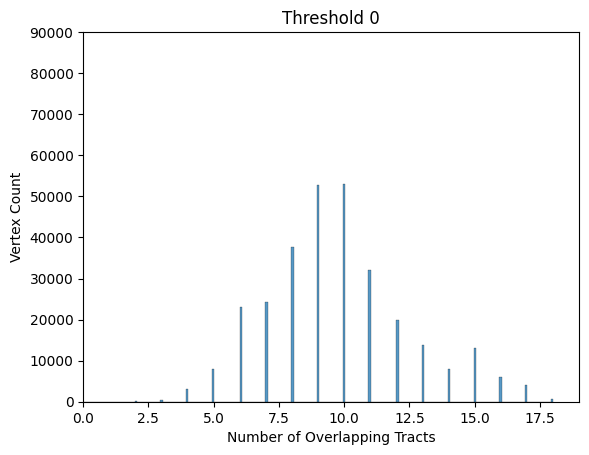

In [31]:
sns.histplot(dat['sum'])
title = 'Threshold ' + threshold
plt.title(title)
plt.xlim([0,19])
plt.ylim([0,90000])
plt.xlabel('Number of Overlapping Tracts')
plt.ylabel('Vertex Count');

### Surface Plots for Seperate Endpoints 
Not working yet

In [13]:
''' #USE ONLY IF WANTING TO SPLIT BY HEMISPHERE OR ROI LATER IN CODE
bi_tract_names = [] # tracts with left and right tract (lh-LPI, lh-RAS, rh-LPI, rh-RAS)
mono_tract_names = [] # tracts with no left and right tract (lh-LPI, rh-RAS)

# for use inside for loop below
LENGTH_HEM = len('rh.')
LENGTH_LEFT = len('left')
LENGTH_RIGHT = len('right')

# extract tract name from file name excluding 'left' or 'right's
for i in file_names:
    if ("rh.left" in i) or ("lh.right" in i) or ('spino' in i) or ('Cerebellar' in i):
        continue # exclude if file name "rh.left..." or "lh.right..."
    else:
        split_by_tract = i.split("_")[0][LENGTH_HEM:]
        if 'left' in split_by_tract:
            bi_tract_names.append(split_by_tract[LENGTH_LEFT:])
        elif 'right' in split_by_tract:
            bi_tract_names.append(split_by_tract[LENGTH_RIGHT:])
        else:
            mono_tract_names.append(split_by_tract)

mono_tract_names = sorted(list(set(mono_tract_names))) # sorted to keep order consistent for future indexing
bi_tract_names = sorted(list(set(bi_tract_names))) # sorted to keep order consistent for future indexing

# create single array with tract names and whether the tracts are mono or bi
ALL_TRACT_NAMES = mono_tract_names + bi_tract_names
isMono = np.concatenate((np.ones(len(mono_tract_names), dtype=int),
                         np.zeros(len(bi_tract_names), dtype=int)))
MONO_OR_BI_DICT = dict(zip(ALL_TRACT_NAMES, isMono)) # binary, 1 = mono tract, 0 = bi tract '''

' #USE ONLY IF WANTING TO SPLIT BY HEMISPHERE OR ROI LATER IN CODE\nbi_tract_names = [] # tracts with left and right tract (lh-LPI, lh-RAS, rh-LPI, rh-RAS)\nmono_tract_names = [] # tracts with no left and right tract (lh-LPI, rh-RAS)\n\n# for use inside for loop below\nLENGTH_HEM = len(\'rh.\')\nLENGTH_LEFT = len(\'left\')\nLENGTH_RIGHT = len(\'right\')\n\n# extract tract name from file name excluding \'left\' or \'right\'s\nfor i in file_names:\n    if ("rh.left" in i) or ("lh.right" in i) or (\'spino\' in i) or (\'Cerebellar\' in i):\n        continue # exclude if file name "rh.left..." or "lh.right..."\n    else:\n        split_by_tract = i.split("_")[0][LENGTH_HEM:]\n        if \'left\' in split_by_tract:\n            bi_tract_names.append(split_by_tract[LENGTH_LEFT:])\n        elif \'right\' in split_by_tract:\n            bi_tract_names.append(split_by_tract[LENGTH_RIGHT:])\n        else:\n            mono_tract_names.append(split_by_tract)\n\nmono_tract_names = sorted(list(set(m

In [14]:
''' # All variables for decoder method

# constants for separation method of bi tracts used inside for loop
SPLIT_ROI = "roi"
SPLIT_HEM = "hem"
SPLIT_BOTH = "both"
figures_dir = op.join(data_dir, f"figures_{smooth}_{threshold}", 'separated')
# modify to run a few tract, lh or rh, lpi or ras
tracts_to_analyze = ALL_TRACT_NAMES # modify to just run a few tracts
hemispheres_to_analyze = ["rh", "lh"]
endpts_to_analyze = ["LPI", "RAS"]
# modify this to choose to split by endpoint ROI (lpi vs. ras), hemisphere (lh vs. rh), or both
split_method = SPLIT_HEM '''

' # All variables for decoder method\n\n# constants for separation method of bi tracts used inside for loop\nSPLIT_ROI = "roi"\nSPLIT_HEM = "hem"\nSPLIT_BOTH = "both"\nfigures_dir = op.join(data_dir, f"figures_{smooth}_{threshold}", \'separated\')\n# modify to run a few tract, lh or rh, lpi or ras\ntracts_to_analyze = ALL_TRACT_NAMES # modify to just run a few tracts\nhemispheres_to_analyze = ["rh", "lh"]\nendpts_to_analyze = ["LPI", "RAS"]\n# modify this to choose to split by endpoint ROI (lpi vs. ras), hemisphere (lh vs. rh), or both\nsplit_method = SPLIT_HEM '

In [15]:

''' map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 104 topics*ROIs data table in long form. Can be anywhere from 33~61 ROIs.

# to keep track of lh-LPI, rh-RAS for mono tracks to not have duplicate iterations
do_not_run_dict = {"lhLPI": False, "rhRAS": False, "lhRAS": True, "rhLPI": True} # true = do not run 
prevTract = ""
endpt = "LPI"

for fig_i, (tract, hem) in enumerate(itertools.product(tracts_to_analyze, hemispheres_to_analyze)): # iterate through endpt
    # Read map
    if MONO_OR_BI_DICT.get(tract): # if mono tract
        if prevTract != tract: # if new track iteration, reset values
            do_not_run_dict["lhLPI"] = False
            do_not_run_dict["rhRAS"] = False
        if do_not_run_dict[hem+endpt]: # check if need to run iteration
            continue
        else:
            map_arr_lh, map_arr_rh = load_mono_maps(endpt_dir, tract, hem)
            do_not_run_dict[hem+endpt] = True
        prevTract = tract
    else: # if bi tract
        map_arr_lh, map_arr_rh = load_bi_maps(endpt_dir, tract, split_method, hemisphere=hem) # CHANGE SPLIT METHOD HERE, endpt=endpt

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    # Visualize maps to decode
    surf_fig = plot_surf_maps(
        map_arr_lh, 
        map_arr_rh, 
        space=SPACE, 
        density=DENSITY, 
        cmap="YlOrRd",
        color_range=(0, 1),
        title=f"{TRACTS_DICT[tract]} LPI+RAS\n{smooth}. Threshold: {threshold}", # MAY NEED TO CHANGE THRESHOLD OR SMOOTHING 
        data_dir=data_dir,
        out_fig=op.join(figures_dir, f"{fig_i}-01_{tract}_{hem}_{endpt}_thr-{smooth}_surf.png"),
    )

    # Decode map and calculate correlation of activation map and white matter termination map
    # temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # # filter to keep only the function-related topics
    # filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
    #     temp_corrs_df,
    #     features,
    #     classification,
    #     pos_corr = False,
    #     freq_by_topic=frequencies,
    #     class_by_topic=class_lst,
    # )

    # # transform and concat into single df for clustering
    # filtered_df = filtered_df.rename(columns={0: 'r'})
    # sorted_df = filtered_df.sort_values(by="r", ascending=False)
    # map_corr_df = pd.concat([map_corr_df, 
    #                          pd.DataFrame({'ROI': f"{hem}_{tract}", #endpt
    #                                        'topic': sorted_df.index, 
    #                                        'r': sorted_df['r']})], 
    #                                        ignore_index=True)
'''

' map_corr_df = pd.DataFrame(columns=[\'ROI\', \'topic\', \'r\']) # 104 topics*ROIs data table in long form. Can be anywhere from 33~61 ROIs.\n\n# to keep track of lh-LPI, rh-RAS for mono tracks to not have duplicate iterations\ndo_not_run_dict = {"lhLPI": False, "rhRAS": False, "lhRAS": True, "rhLPI": True} # true = do not run \nprevTract = ""\nendpt = "LPI"\n\nfor fig_i, (tract, hem) in enumerate(itertools.product(tracts_to_analyze, hemispheres_to_analyze)): # iterate through endpt\n    # Read map\n    if MONO_OR_BI_DICT.get(tract): # if mono tract\n        if prevTract != tract: # if new track iteration, reset values\n            do_not_run_dict["lhLPI"] = False\n            do_not_run_dict["rhRAS"] = False\n        if do_not_run_dict[hem+endpt]: # check if need to run iteration\n            continue\n        else:\n            map_arr_lh, map_arr_rh = load_mono_maps(endpt_dir, tract, hem)\n            do_not_run_dict[hem+endpt] = True\n        prevTract = tract\n    else: # if bi t

### Creating Complete Dataframe With Proportion Similarity: Tract vs Tract
Use if wanting to see how similar is one tract to another in terms of shared vertices

In [16]:
# ### TAKES 20 TO 50 MINS T0 RUN
# sim_dat = pd.DataFrame(index=dat.columns, columns = dat.drop('sum', axis = 1).columns)
# plot_sim = []
# for col1 in dat:
#     den = dat[col1].sum()
#     for col2 in dat:
#         num = 0
#         for row in range(dat.shape[0]):
#             if dat[col1][row] != 0 and (dat[col1][row] == dat[col2][row]) :
#                 num += 1
#         sim = num/den
#         plot_sim.append(sim)
#         sim_dat.loc[col2,col1] = sim
# sim_dat = sim_dat.drop('sum').drop('sum', axis = 1)
# sim_dat = sim_dat.astype(float)


### Tract by Tract Similarity Proportion - Visualizations

In [17]:
# sns.histplot(plot_sim, bins = 10)
# title = 'Distribution of Tract Similarity Proportion: Treshold ' + threshold
# plt.title(title);

In [18]:
# sns.heatmap(sim_dat)
# title = 'Proportion of Tract by Tract Similarity: Threshold ' + threshold
# plt.title(title);

### Brain Map Surface Covered by Tracts

In [19]:
test_dat = pd.concat([dat,(dat.sum()/299880).to_frame().T], ignore_index = True)  ### last row contains relevant info

#### Checks for 15% requirement

In [20]:
coverage_proportions = (dat.drop('sum', axis = 1).sum()/299881)

# Apply the condition and filter the columns
filtered_tracts = coverage_proportions[coverage_proportions > 0.15]

# Print the tracts that meet the condition
print(filtered_tracts)
print('Number of Tracts Meeting Requirement:', len(filtered_tracts))

anterioFrontalCC        0.212764
forcepsMajor            0.309586
forcepsMinor            0.151067
leftArc                 0.383475
leftCST                 0.160560
leftIFOF                0.259169
leftILF                 0.214072
leftMDLFang             0.187288
leftMDLFspl             0.218550
leftSLF1And2            0.332002
leftSLF3                0.294724
leftTPC                 0.240219
leftcingulum            0.450132
leftmotorThalamic       0.183576
leftpArc                0.192103
leftparietoThalamic     0.228321
middleFrontalCC         0.326399
parietalCC              0.315318
rightArc                0.375832
rightCST                0.163845
rightIFOF               0.252734
rightILF                0.219230
rightMDLFang            0.199052
rightMDLFspl            0.224592
rightSLF1And2           0.342342
rightSLF3               0.294280
rightTPC                0.250679
rightbaum               0.152774
rightcingulum           0.278480
rightmotorThalamic      0.187568
rightpArc 

#### Checks for 10,000 vertices requirement

In [21]:
num_ver = dat.drop('sum', axis = 1).sum()
filtered_tracts = num_ver[num_ver >= 10000]
print(filtered_tracts)
print('Number of Tracts Meeting Requirement:', len(filtered_tracts))

anterioFrontalCC         63804.0
forcepsMajor             92839.0
forcepsMinor             45302.0
leftArc                 114997.0
leftAslant               40300.0
leftCST                  48149.0
leftIFOF                 77720.0
leftILF                  64196.0
leftMDLFang              56164.0
leftMDLFspl              65539.0
leftSLF1And2             99561.0
leftSLF3                 88382.0
leftTPC                  72037.0
leftUncinate             44261.0
leftVOF                  36318.0
leftbaum                 44634.0
leftcingulum            134986.0
leftfrontoThalamic       40768.0
leftmeyer                41737.0
leftmotorThalamic        55051.0
leftpArc                 57608.0
leftparietoThalamic      68469.0
lefttemporoThalamic      29185.0
middleFrontalCC          97881.0
parietalCC               94558.0
rightArc                112705.0
rightAslant              42380.0
rightCST                 49134.0
rightIFOF                75790.0
rightILF                 65743.0
rightMDLFa

### Surface Covered by Tracts - Visualization

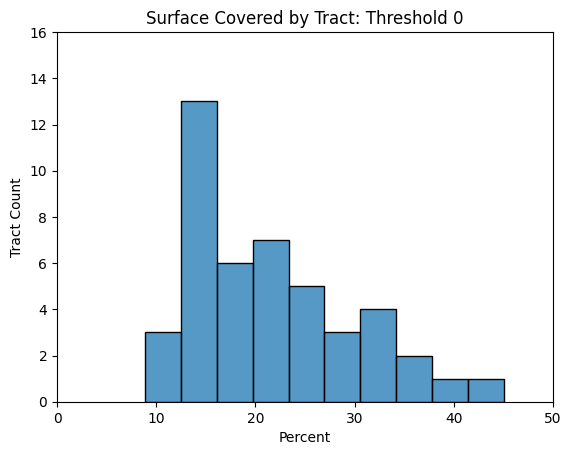

In [27]:
import seaborn as sns
sns.histplot((dat.drop('sum',axis = 1).sum()/299881)*100, bins = 10)
plt.xlabel('Percent')
plt.ylabel('Tract Count')
plt.xlim([0,50])
plt.ylim([0,16])
title = 'Surface Covered by Tract: Threshold ' + threshold
plt.title(title);

## HCA

In [23]:
# constant to choose whether to cluster by topic or endpoint ROI
TOPIC = 't'
ROI = 'r'

clusterby = ROI # CHANGE THIS!!!

# transform and clean df
if clusterby == ROI:
    pivot_df = map_corr_df.pivot(index = 'topic', columns='ROI', values='r') # pivot from long to wide
elif clusterby == TOPIC:
    pivot_df = map_corr_df.pivot(index = 'ROI', columns='topic', values='r') # pivot from long to wide
else:
    print("Error: Incorrect clustering method provided")
pivot_df_cleaned = pivot_df.dropna(axis=1) # drop cols with NA values
# note to self: pivot_df.to_csv('output.csv', index=True)

# compute correlation matrix and HCA
corr_mtrix = pivot_df_cleaned.corr(method='pearson') 

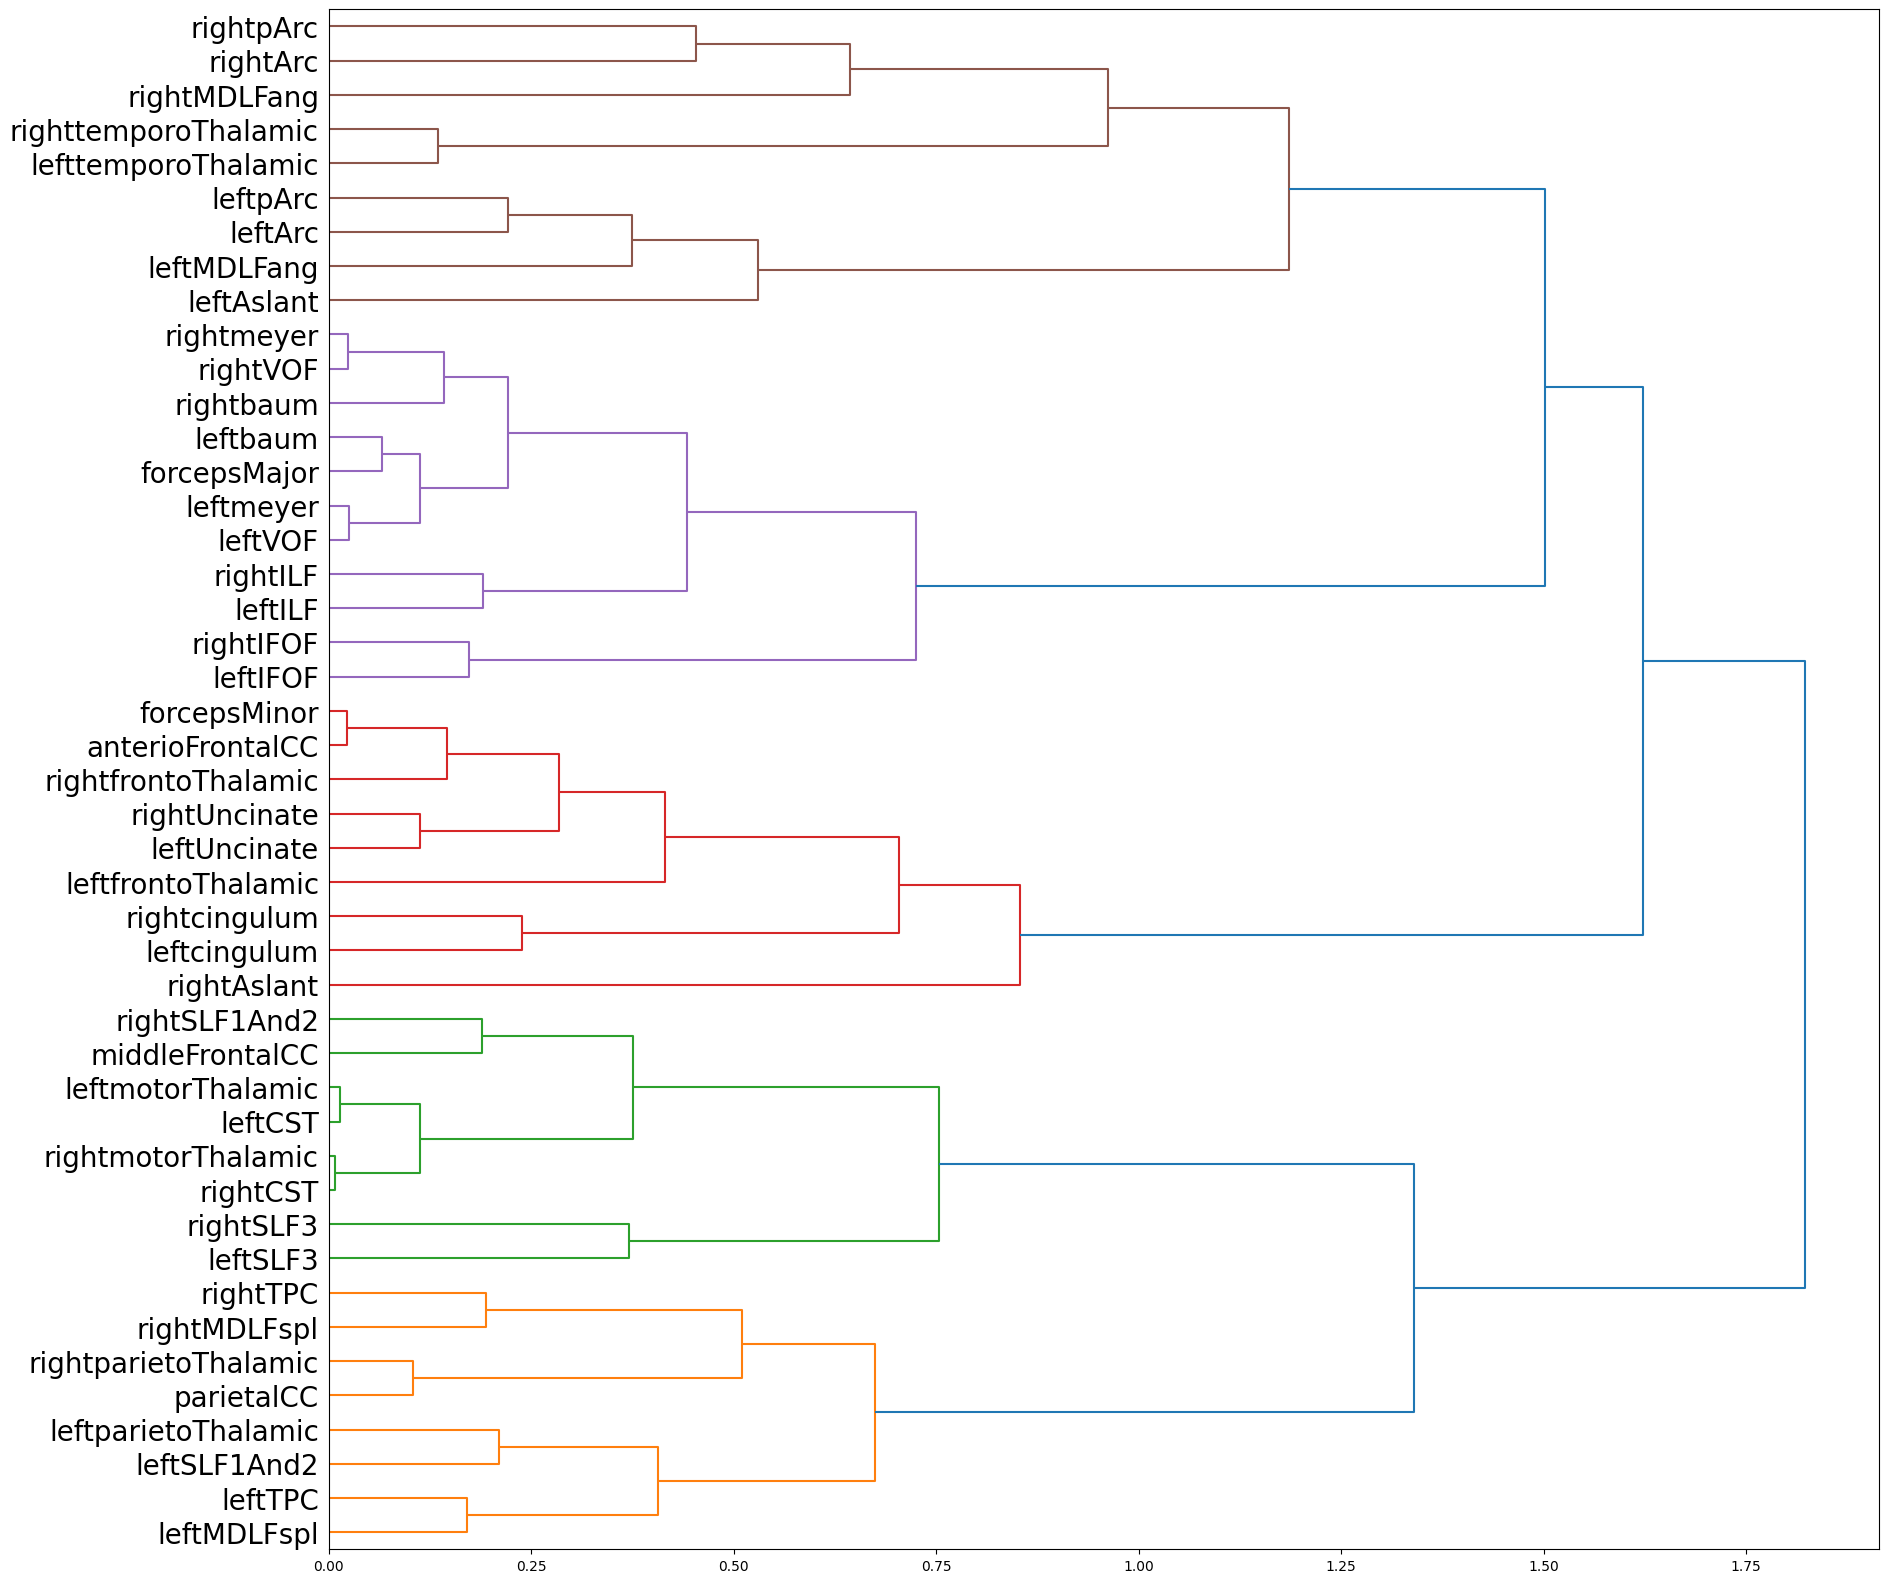

In [24]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree, inconsistent, fcluster, cophenet
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# HCA
link_method = 'complete'
dissimilarity = 1 - corr_mtrix # distance matrix
hca = linkage(squareform(dissimilarity), link_method)

# plot dendrogram
plt.figure(figsize=(20,20)) #45, 30
dendrogram(hca, labels=corr_mtrix.columns, 
           orientation='right',
           leaf_font_size=20)
plt.savefig('./dendro_' + link_method + '.png', 
            bbox_inches = 'tight');
#thresh = 1.5
#plt.axhline(y=thresh, c='k')

### Evaluating Dendrogram

In [32]:
# cophenetic correlation coefficient 
cophen_mrtix = squareform(cophenet(hca))
cophen_r = np.corrcoef(squareform(dissimilarity), squareform(cophen_mrtix))
print(cophen_r[0][1])

# another way to calculate cophenetic correlation coefficient
import scipy
y = scipy.spatial.distance.pdist(1-corr_mtrix)
scipy.cluster.hierarchy.cophenet(hca,y)[0]

0.7216113599084403


0.7301229657871311